In [1]:
#%pip install --no-cache-dir autogluon

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from autogluon.tabular import TabularPredictor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, auc

import warnings
warnings.filterwarnings("ignore", message="load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")

In [3]:
# Load data (without smote)
X_train = pd.read_pickle('X_train_preprocessed_binary.pkl')
X_test = pd.read_pickle('X_test_preprocessed_binary.pkl')

y_train = pd.read_pickle('y_train_binary.pkl')
y_test = pd.read_pickle('y_test_binary.pkl')

In [4]:
# Combine data
train_data = pd.DataFrame(X_train).reset_index(drop=True)
train_data['Y'] = y_train.reset_index(drop=True)
train_data['weight'] = compute_sample_weight('balanced', y_train)

test_data = pd.DataFrame(X_test).reset_index(drop=True)
test_data['Y'] = y_test.reset_index(drop=True)

train_data['Возраст (рассчитывается автоматически)'] = pd.to_numeric(
    train_data['Возраст (рассчитывается автоматически)'], errors='coerce'
)
train_data['count_disease'] = pd.to_numeric(
    train_data['count_disease'], errors='coerce'
)

test_data['Возраст (рассчитывается автоматически)'] = pd.to_numeric(
    test_data['Возраст (рассчитывается автоматически)'], errors='coerce'
)
test_data['count_disease'] = pd.to_numeric(
    test_data['count_disease'], errors='coerce'
)



In [5]:
# Combine data
train_data = pd.DataFrame(X_train).reset_index(drop=True)
train_data['Y'] = y_train.reset_index(drop=True)
train_data['weight'] = compute_sample_weight('balanced', y_train)

test_data = pd.DataFrame(X_test).reset_index(drop=True)
test_data['Y'] = y_test.reset_index(drop=True)

# Convert known problematic columns to numeric
for col in ['Возраст (рассчитывается автоматически)', 'count_disease']:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')
    test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

# Ensure all other columns are also numeric
def convert_all_to_numeric(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

train_data = convert_all_to_numeric(train_data)
test_data = convert_all_to_numeric(test_data)

In [6]:
# TabularPredictor
hp = {
        'num_bag_folds': 0,
        'num_stack_levels': 0,
        'presets': 'medium_quality'  # 'experimental_quality', 'best_quality', 'medium_quality'
    }

predictor = TabularPredictor(label='Y', eval_metric='roc_auc', sample_weight='weight').fit(train_data=train_data, **hp)
predictions = predictor.predict(test_data)


No path specified. Models will be saved in: "AutogluonModels/ag-20250526_180155"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       11.40 GB / 12.67 GB (90.0%)
Disk Space Avail:   67.21 GB / 107.72 GB (62.4%)
Presets specified: ['medium_quality']
Values in column 'weight' used as sample weights instead of predictive features. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "/content/AutogluonModels/ag-20250526_180155"
Train Data Rows:    18508
Train Data Columns: 114
Label Column:       Y
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label valu

In [7]:
scores = predictor.evaluate(test_data)
print(scores)

{'roc_auc': np.float64(0.8722650575483294), 'accuracy': 0.8074346228657878, 'balanced_accuracy': np.float64(0.7966939642098878), 'mcc': np.float64(0.5635535545326509), 'f1': 0.6972477064220184, 'precision': 0.6360818350898946, 'recall': 0.7714285714285715}


In [8]:
predictor.leaderboard(test_data, extra_metrics=['balanced_accuracy','f1', 'precision', 'recall'], extra_info=True)

,model,score_test,balanced_accuracy,f1,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val,...,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
0,LightGBM,0.872953,0.801014,0.693839,0.598365,0.825564,0.862969,roc_auc,0.071246,0.039119,...,{'learning_rate': 0.05},{'num_boost_round': 186},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': ['bool', 'int', 'float', 'category'], 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None}","[Возраст (рассчитывается автоматически), count_disease, Пол_2, Был ли в заключении ранее_1, Был ли в заключении ранее_2, Был ли в заключении ранее_3, Бытовое пьянство_1, Бытовое пьянство_2, Жилищные условия_1, Жилищные условия_10, Жилищные условия_2, Жилищные условия_3, Жилищные условия_4, Жилищные условия_5, Жилищные условия_8, Инфильтративный туберкулез_1, Инфильтративный туберкулез_2, Инфильтративный туберкулез_3, Инфильтративный туберкулез_4, Инфильтративный туберкулез_5, Инфильтративный туберкулез_6, Распад_1, Распад_2, Фаза туберкулеза органов дыхания_1, Фаза туберкулеза органов дыха...",None,None,None,None,[],[WeightedEnsemble_L2]
1,LightGBMXT,0.872912,0.804555,0.698042,0.601852,0.830827,0.860929,roc_auc,0.082615,0.117073,...,"{'learning_rate': 0.05, 'extra_trees': True}",{'num_boost_round': 213},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': ['bool', 'int', 'float', 'category'], 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None}","[Возраст (рассчитывается автоматически), count_disease, Пол_2, Был ли в заключении ранее_1, Был ли в заключении ранее_2, Был ли в заключении ранее_3, Бытовое пьянство_1, Бытовое пьянство_2, Жилищные условия_1, Жилищные условия_10, Жилищные условия_2, Жилищные условия_3, Жилищные условия_4, Жилищные условия_5, Жилищные условия_8, Инфильтративный туберкулез_1, Инфильтративный туберкулез_2, Инфильтративный туберкулез_3, Инфильтративный туберкулез_4, Инфильтративный туберкулез_5, Инфильтративный туберкулез_6, Распад_1, Распад_2, Фаза туберкулеза органов дыхания_1, Фаза туберкулеза органов дыха...",None,None,None,None,[],[]
2,WeightedEnsemble_L2,0.872265,0.796694,0.697248,0.636082,0.771429,0.867478,roc_auc,1.514495,0.474997,...,"{'use_orig_features': False, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True, 'stratify': 'auto', 'bin': 'auto', 'n_bins': None}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}","[XGBoost, NeuralNetTorch, LightGBM, NeuralNetFastAI, RandomForestGini, CatBoost]",None,"{'ensemble_size': 25, 'subsample_size': 1000000}",{'ensemble_size': 21},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}","[XGBoost, NeuralNetTorch, LightGBM, NeuralNetFastAI, RandomForestGini, CatBoost]",[]
3,CatBoost,0.870313,0.799773,0.694008,0.604690,0.814286,0.862812,roc_auc,0.076789,0.

In [9]:
choice = 2
model_name = predictor.leaderboard(silent=True).iloc[choice]['model']
model = predictor._trainer.load_model(model_name)

print(model_name)

# Prepare test data for prediction
X_test_processed = test_data.drop(columns=['Y'])

# Classification report
class_names = ['Treatment success', 'Treatment fail + Death']
y_pred = model.predict(X_test_processed)
y_true = test_data['Y']

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

LightGBM

Classification Report:
                        precision    recall  f1-score   support

     Treatment success      0.917     0.776     0.841      3297
Treatment fail + Death      0.598     0.826     0.694      1330

              accuracy                          0.791      4627
             macro avg      0.758     0.801     0.767      4627
          weighted avg      0.825     0.791     0.799      4627



# Feature importance

In [10]:
# Map to translated features (preserving different diseases)
column_rename_map = {
    'Пол': 'Gender',
    'Возраст (рассчитывается автоматически)': 'Age',
    'social': 'Social and occupational affiliation',
    'count': 'Number of comorbidities',
    'Был ли в заключении ранее': 'Prior incarceration',
    'Бытовое пьянство': 'Domestic drunkenness',
    'Жилищные условия': 'Housing conditions',
    'Diagnosis': 'Diagnosis of pulmonary tuberculosis',
    'Инфильтративный туберкулез': 'Infiltrative tuberculosis',
    'Распад': 'Dispersion',
    'Фаза туберкулеза органов дыхания': 'Respiratory tuberculosis phase',
    'Фаза внелегочного туберкулеза': 'Extrapulmonary TB phase',
    'Бактериовыделение': 'Bacterial excretion',
    'Устойчивость к R (рифампицин)': 'Resistance to R (rifampicin)',
    'Устойчивость к H (изониазид)': 'Resistance to H (isoniazid)',
    'Устойчивость к E (этамбутол)': 'Resistance to E (ethambutol)',
    'Устойчивость к S (стрептомицин)': 'Resistance to S (streptomycin)',
    'Метод выявления туберкулеза': 'Method of tuberculosis detection',
    'Медицинская группа риска': 'Medical risk group',
    'Хирургическое лечение на данном этапе лечения': 'Surgical treatment',
    'Инвалидность': 'Disability',
    'disease': 'Comorbidities',

    # Diseases mapping
    'disease_0': 'No information',
    'disease_1': 'None comorbidities',
    'disease_2': 'Diabetes',
    'disease_3': 'Chronic non-specific lung diseases',
    'disease_4': 'Hypertensive heart disease, Coronary heart disease',
    'disease_5': 'Gastric and 12 p/k ulcers',
    'disease_6': 'Psychiatric diseases',
    'disease_7': 'Oncological diseases',
    'disease_8': 'Chronic alcoholism',
    'disease_9': 'Drug addiction',
    'disease_10': 'Toxicomania',
    'disease_11': 'Renal and urinary tract diseases',
    'disease_12': 'Diseases of peripheral vessels',
    'disease_13': 'Liver and biliary tract diseases',
    'disease_14': 'Endocrinological diseases (except diabetes)',
    'disease_15': 'Inactive TOD',
    'disease_16': 'Inactive TVL',
    'disease_17': 'HIV',
    'disease_18': 'Other comorbidities'
}

In [11]:
def map_feature_name(raw_name):
    """Map raw feature name to human-readable label using column_rename_map."""
    if raw_name.startswith('disease_17'):
        return column_rename_map.get(raw_name, raw_name)

    base = raw_name.split('_')[0]
    return column_rename_map.get(base, base)

def aggregate_shap_values(feature_names, shap_values_array, ohe_group_map):
    """Aggregate SHAP values for grouped one-hot encoded features."""
    aggregated = {}

    for feature, encoded_columns in ohe_group_map.items():
        indices = [i for i, name in enumerate(feature_names) if name == feature]
        if indices:
            avg_impact = np.abs(shap_values_array[:, indices]).mean()
            aggregated[feature] = avg_impact

    # Add individual features that are not part of any OHE group
    for name in feature_names:
        if name not in ohe_group_map.keys():
            idx = feature_names.index(name)
            aggregated[name] = np.abs(shap_values_array[:, idx]).mean()

    return aggregated


def plot_aggregated_shap(aggregated_dict, model_name):
    """
    Plot aggregated SHAP values as a horizontal bar chart sorted by importance.
    All bars are colored with the specified color: #E08E79.
    """
    # Sort features by absolute importance and select top 20
    items = sorted(aggregated_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:20]
    features, values = zip(*items)

    # Use the specified color uniformly
    color = '#E08E79'

    # Calculate figure height dynamically
    num_features = len(features)
    fig_height = max(6, num_features * 0.5)

    # Create the plot
    plt.figure(figsize=(10, fig_height))
    bars = plt.barh(features, values, color=color)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}",
            ha="left",
            va="center",
            fontsize=8,
            color="white"
        )

    # Customize the plot
    plt.title(f'{model_name}', fontsize=14)
    plt.xlabel("Mean |SHAP Value|", fontsize=12)
    plt.gca().invert_yaxis()  # Top-to-bottom ordering
    plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    plt.show()

In [12]:
ohe_groups = {
    'Gender': [
        'Пол_2'
    ],
    'Prior incarceration': [
        'Был ли в заключении ранее_1',
        'Был ли в заключении ранее_2',
        'Был ли в заключении ранее_3'
    ],
    'Domestic drunkenness': [
        'Бытовое пьянство_1',
        'Бытовое пьянство_2'
    ],
    'Housing conditions': [
        'Жилищные условия_1', 'Жилищные условия_2', 'Жилищные условия_3',
        'Жилищные условия_4', 'Жилищные условия_5', 'Жилищные условия_6',
        'Жилищные условия_7', 'Жилищные условия_8', 'Жилищные условия_10',
        'Жилищные условия_11'
    ],
    'Infiltrative tuberculosis': [
        'Инфильтративный туберкулез_1', 'Инфильтративный туберкулез_2',
        'Инфильтративный туберкулез_3', 'Инфильтративный туберкулез_4',
        'Инфильтративный туберкулез_5', 'Инфильтративный туберкулез_6'
    ],
    'Dispersion': [
        'Распад_1', 'Распад_2'
    ],
    'Respiratory tuberculosis phase': [
        'Фаза туберкулеза органов дыхания_1', 'Фаза туберкулеза органов дыхания_2',
        'Фаза туберкулеза органов дыхания_3', 'Фаза туберкулеза органов дыхания_4',
        'Фаза туберкулеза органов дыхания_5', 'Фаза туберкулеза органов дыхания_6',
        'Фаза туберкулеза органов дыхания_7', 'Фаза туберкулеза органов дыхания_8'
    ],
    'Extrapulmonary TB phase': [
        'Фаза внелегочного туберкулеза_1', 'Фаза внелегочного туберкулеза_2',
        'Фаза внелегочного туберкулеза_3', 'Фаза внелегочного туберкулеза_4',
        'Фаза внелегочного туберкулеза_5'
    ],
    'Bacterial excretion': [
        'Бактериовыделение_1', 'Бактериовыделение_2'
    ],
    'Resistance to R (rifampicin)': [
        'Устойчивость к R (рифампицин)_1', 'Устойчивость к R (рифампицин)_2'
    ],
    'Resistance to H (isoniazid)': [
        'Устойчивость к H (изониазид)_1', 'Устойчивость к H (изониазид)_2'
    ],
    'Resistance to E (ethambutol)': [
        'Устойчивость к E (этамбутол)_1', 'Устойчивость к E (этамбутол)_2'
    ],
    'Resistance to S (streptomycin)': [
        'Устойчивость к S (стрептомицин)_1', 'Устойчивость к S (стрептомицин)_2'
    ],
    'Method of tuberculosis detection': [
        'Метод выявления туберкулеза_1', 'Метод выявления туберкулеза_2',
        'Метод выявления туберкулеза_3', 'Метод выявления туберкулеза_4',
        'Метод выявления туберкулеза_5', 'Метод выявления туберкулеза_6',
        'Метод выявления туберкулеза_7', 'Метод выявления туберкулеза_8',
        'Метод выявления туберкулеза_9'
    ],
    'Medical risk group': [
        'Медицинская группа риска_1', 'Медицинская группа риска_2',
        'Медицинская группа риска_3', 'Медицинская группа риска_4',
        'Медицинская группа риска_5', 'Медицинская группа риска_6',
        'Медицинская группа риска_7', 'Медицинская группа риска_8',
        'Медицинская группа риска_9', 'Медицинская группа риска_10',
        'Медицинская группа риска_11', 'Медицинская группа риска_12',
        'Медицинская группа риска_13', 'Медицинская группа риска_14',
        'Медицинская группа риска_15', 'Медицинская группа риска_16',
        'Медицинская группа риска_17'
    ],
    'Surgical treatment': [
        'Хирургическое лечение на данном этапе лечения_1',
        'Хирургическое лечение на данном этапе лечения_2',
        'Хирургическое лечение на данном этапе лечения_3',
        'Хирургическое лечение на данном этапе лечения_4'
    ],
    'Disability': [
        'Инвалидность_1', 'Инвалидность_2', 'Инвалидность_3'
    ],
    'Social and occupational affiliation': [
        'social_status_Employee', 'social_status_No information',
        'social_status_Not working (working age)', 'social_status_Other',
        'social_status_Pensioner', 'social_status_Worker'
    ],
    'Diagnosis of pulmonary tuberculosis': [
        'Diagnosis_pulmonary_tb_Disseminated',
        'Diagnosis_pulmonary_tb_Focal',
        'Diagnosis_pulmonary_tb_Infiltrative',
        'Diagnosis_pulmonary_tb_No information',
        'Diagnosis_pulmonary_tb_Other',
        'Diagnosis_pulmonary_tb_Tuberculoma'
    ],
    'Disease': [
        'disease_1', 'disease_2', 'disease_3',
        'disease_4', 'disease_5', 'disease_6',
        'disease_7', 'disease_8', 'disease_9',
        'disease_10', 'disease_11', 'disease_12',
        'disease_13', 'disease_14', 'disease_15',
        'disease_16', 'disease_17', 'disease_18',
        'disease_19'
    ]
}

In [13]:
unused_features = ['Жилищные условия_11', 'Жилищные условия_6', 'Жилищные условия_7', 'Метод выявления туберкулеза_6', 'Медицинская группа риска_5', 'disease_10']

In [14]:
column_names = X_train.columns

unused_features = ['Жилищные условия_11', 'Жилищные условия_6', 'Жилищные условия_7', 'Метод выявления туберкулеза_6', 'Медицинская группа риска_5', 'disease_10']

# Filter out unused features
filtered_column_names = [col for col in column_names if col not in unused_features]

# Optional: Also update mapped feature names to match the filtered columns
mapped_shap_feature_names = [map_feature_name(name) for name in filtered_column_names]

## LightGBM (AutoGluon best model) – Feature importance

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
<ipython-input-15-eb2603dd0d6c>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_background, title="AutoGluon (LightGBM)")


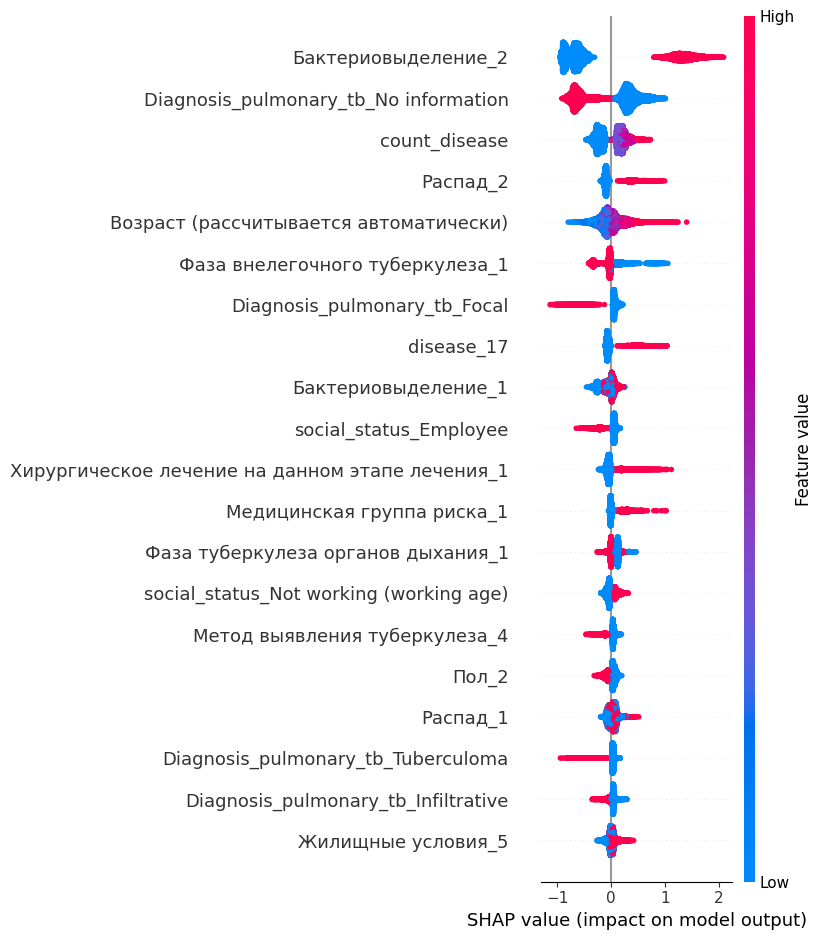

In [15]:
# Get preprocessed background data
X_background = predictor.transform_features(train_data)

#Generate SHAP values
explainer = shap.TreeExplainer(model.model)
shap_values = explainer.shap_values(X_background)

# Visualize
shap.summary_plot(shap_values, X_background, title="AutoGluon (LightGBM)")

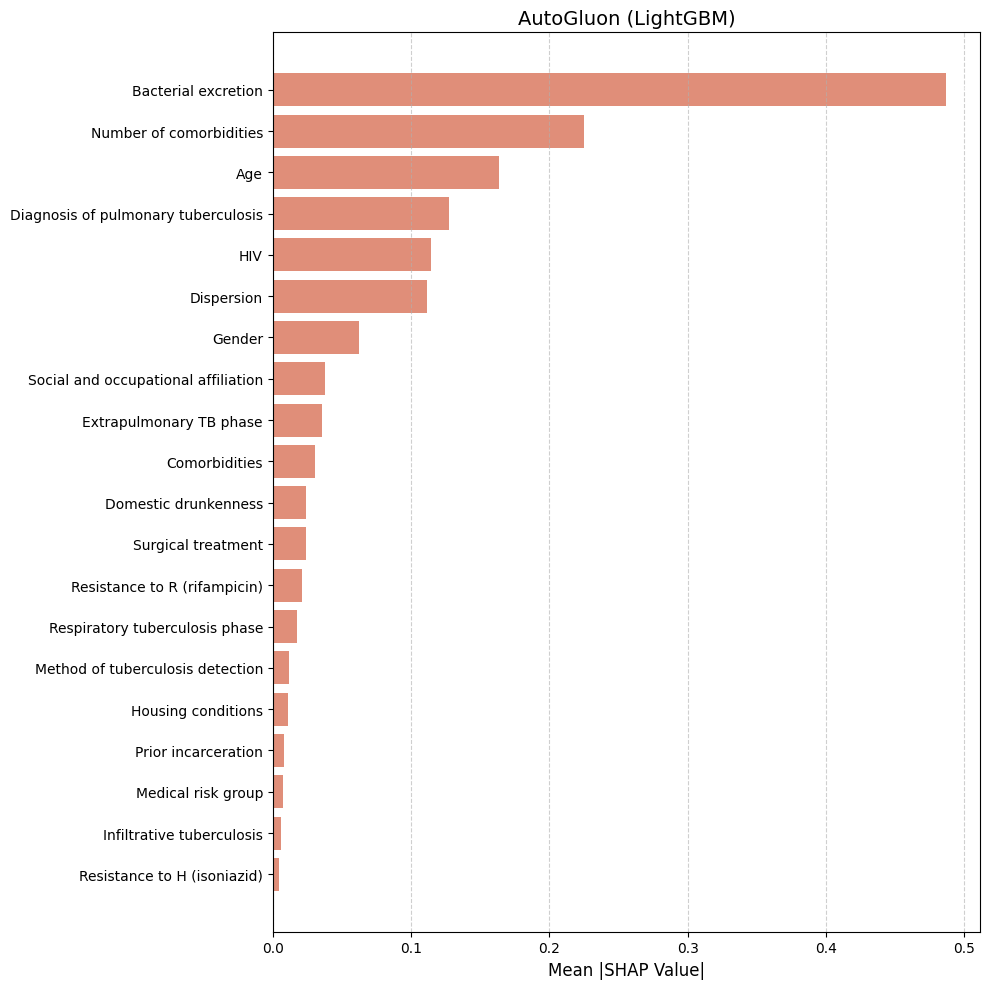

In [16]:
# Aggregate SHAP values
aggregated_dict = aggregate_shap_values(mapped_shap_feature_names, shap_values, ohe_groups)

# Plot top 20 features
plot_aggregated_shap(aggregated_dict, 'AutoGluon (LightGBM)')
